In [36]:
# Standard libraries
import os
import sys
import json
import ast
import pickle
import warnings

# Numerical and data manipulation libraries
import numpy as np
import pandas as pd
from collections import Counter
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans

# Torch and related libraries
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor

# Ultralytics for YOLO
import ultralytics
from ultralytics import YOLO

# Image processing libraries
import cv2
from PIL import Image

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import display, Image
from tqdm import tqdm

# Seed for reproducibility
np.random.seed(42)

In [37]:
def render(image):
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
    if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_bytes = cv2.imencode('.jpg', image)[1].tobytes()
    display(Image(data=img_bytes))

def loadImage(path):
    return cv2.imread(path)

def get_file_names(directory):
    file_names = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            file_names.append(filename)
    return file_names

def run_yolo(yolo, image_url, conf=0.25, iou=0.7, showImage=False):
    results = yolo(image_url, conf=conf, iou=iou, verbose=False)
    img = cv2.cvtColor(results[0].plot()[:, :, [2,1,0]], cv2.COLOR_BGR2RGB)
    if showImage:
        render(img)
    bounding_boxes = results[0].boxes.xyxy.tolist()
    return bounding_boxes

def display_yolo_result(model, img_path):
    bbs = run_yolo(model, img_path)
    img = loadImage(img_path)
    img_bb = drawBB(img, bbs)
    img_bb = cv2.resize(img_bb, (0, 0), fx=3, fy=3)
    render(img_bb)
    return bbs

def drawBB(img, bbs):
    img = img.copy()
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    return img

def getBBImages(image, bbs):
    bb_imgs = []
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        cropped = image[y1:y2, x1:x2]
        bb_imgs.append(cropped)
    return bb_imgs
        
def getGrabCutMask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, img.shape[1] - 1, img.shape[0] - 1)
    iterCount = 10
    cv2.grabCut(img, mask, rect, bgModel, fgModel, iterCount, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    return mask

def maskLego(lego_img):
    
    def reduce_colors_mean_shift(img, spatial_radius, color_radius):
        # Convert image to Lab color space
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        
        # Perform mean shift clustering
        shifted_img = cv2.pyrMeanShiftFiltering(lab_img, spatial_radius, color_radius)
        
        # Convert the result back to BGR color space
        result_img = cv2.cvtColor(shifted_img, cv2.COLOR_Lab2BGR)
        
        return result_img
    
    spatial_radius = 50
    color_radius = 5

    # Reduce colors using mean shift clustering
    lego_img = reduce_colors_mean_shift(lego_img, spatial_radius, color_radius)

    bbColorBlurQnt = 1
    
    fg_mask = np.zeros(lego_img.shape[:2], np.uint8)
    
    while fg_mask.sum() == 0:
        lego_img_blurred = cv2.GaussianBlur(lego_img, (bbColorBlurQnt, bbColorBlurQnt), 0)
        fg_mask = getGrabCutMask(lego_img)
        bbColorBlurQnt -= 2
        if bbColorBlurQnt < 1 and fg_mask.sum() == 0:
            print('Failed to mask image')
            break
    
    # Masked image
    masked = cv2.bitwise_and(lego_img_blurred, lego_img_blurred, mask=fg_mask)
    return masked, fg_mask


def get_jaccard_index(ground_truth, predicted):
    x1, y1, x2, y2 = ground_truth
    x1_p, y1_p, x2_p, y2_p = predicted
    intersection = max(0, min(x2, x2_p) - max(x1, x1_p)) * max(0, min(y2, y2_p) - max(y1, y1_p))
    area_gt = (x2 - x1) * (y2 - y1)
    area_p = (x2_p - x1_p) * (y2_p - y1_p)
    union = area_gt + area_p - intersection
    return intersection / union

def getGroundTruths(id):
    global df_values
    bbs_normalized = ast.literal_eval(df_values[df_values['id'] == id]['bb_list'].values[0])
    bbs = [[i*224 for i in bb] for bb in bbs_normalized] 
    return bbs
    
def match_bounding_boxes(gt_boxes, pred_boxes):
    num_gt = len(gt_boxes)
    num_pred = len(pred_boxes)
    
    # Create an IoU matrix where each entry (i, j) is the IoU between gt_boxes[i] and pred_boxes[j]
    iou_matrix = np.zeros((num_gt, num_pred))
    for i in range(num_gt):
        for j in range(num_pred):
            iou_matrix[i, j] = get_jaccard_index(gt_boxes[i], pred_boxes[j])
    
    # Use the Hungarian algorithm to find the best matching
    row_indices, col_indices = linear_sum_assignment(-iou_matrix)
    
    matches = []
    for row, col in zip(row_indices, col_indices):
        if iou_matrix[row, col] > 0:  # Only consider positive IoU matches
            matches.append((row, col, iou_matrix[row, col]))
    
    return matches

def getFRCNNModel():
    def get_model(num_classes):
        # Load a pre-trained model for classification and return only the features
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        # Get the number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        
        # Replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    num_classes = 2 # 1 class (lego) + background
    model = get_model(num_classes)
    model.load_state_dict(torch.load('models/trained_faster.pth', map_location=torch.device('cpu')))
    model.eval() # Set model to evaluation mode
    return model

def run_frcnn(model, image_path):
    def predict(model, image_path):
        image = loadImage(image_path)
        image_tensor = F.to_tensor(image).unsqueeze(0)
        with torch.no_grad():
            prediction = model(image_tensor)
        return prediction

    prediction = predict(model, image_path)[0]
    image = loadImage(image_path)

    # Draw boxes on the image
    boxes = prediction['boxes']
    scores = prediction['scores']

    for box, score in zip(boxes, scores):
        box = [int(i) for i in box.tolist()]
        if score > 0.5:
            image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 1)
        
    # upscale image by 3x
    image = cv2.resize(image, (0, 0), fx=3, fy=3)
    render(image)
    return boxes.tolist()
    
def getSegmentationImg(img, bbs):
    bb_imgs = getBBImages(img, bbs)
    masks = []

    for box in bb_imgs:
        # render(box)
        img_lego, mask = maskLego(box)
        masks.append(mask)
        # render(img_lego)


    img_neon = img.copy()

    for mask, bb in zip(masks, bbs):
        x1, y1, x2, y2 = [int(x) for x in bb]
        
        # Apply the neon effect to the bounding box
        for y in range(y1, y2):
            for x in range(x1, x2):
                if mask[y - y1, x - x1]:
                    neon = (img_neon[y, x] + [255, 0, 255] ) / 2
                    img_neon[y, x] = np.uint8(neon)
        
    # Display the image with the neon bounding boxes
    img_neon = cv2.resize(img_neon, (0, 0), fx=3, fy=3)
    render(img_neon)


In [38]:
model_faster = getFRCNNModel()
model_yolo = YOLO('models/trained_yolo.pt')

/home/m/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/m/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


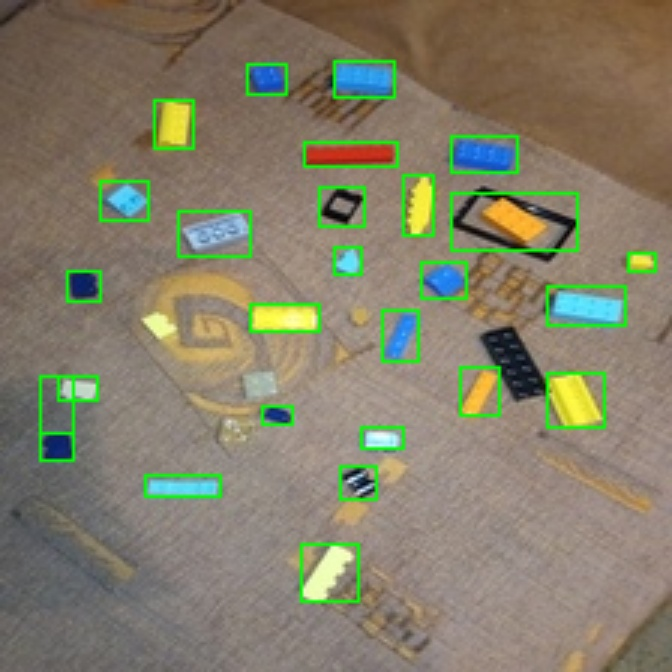

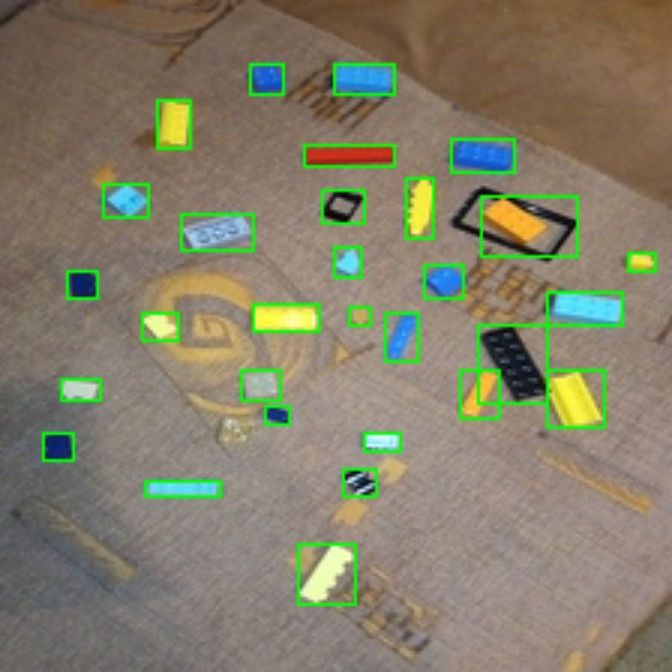

In [39]:
name = '32_1.jpg'
test_image = '../data/imgs/' + name

bbs = display_yolo_result(model_yolo, test_image)
bbs = run_frcnn(model_faster, test_image)

Failed to mask image
Failed to mask image
Failed to mask image
Failed to mask image
Failed to mask image
Failed to mask image
Failed to mask image
Failed to mask image


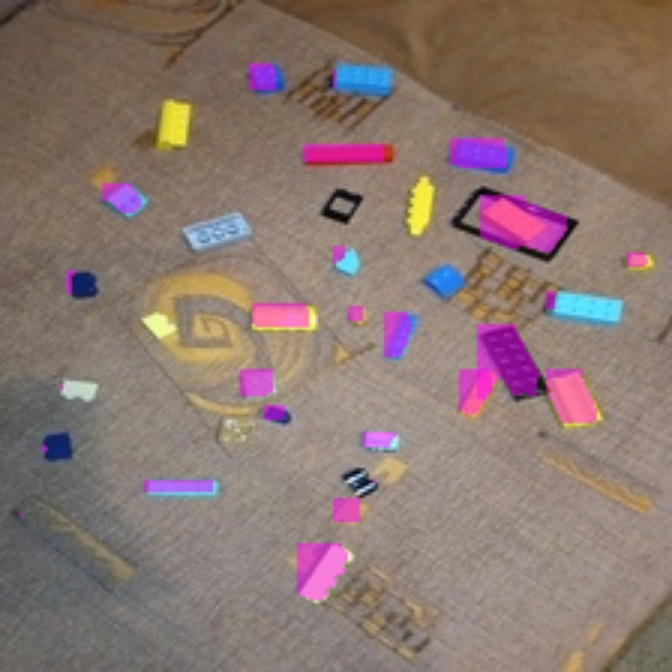

In [40]:
getSegmentationImg(loadImage(test_image), bbs)